In [1]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg

## 2. Camera pose estimation using CHARUCO chessboard

First, let's create the board.

/home/kulinar/Рабочий стол/НИР 3 курс/result


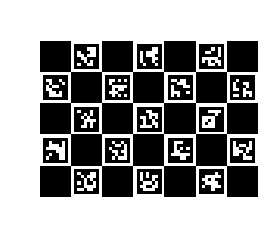

In [2]:
print(os.getcwd())
workdir = "./workdir/"
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
imboard = board.draw((2000, 2000))
cv2.imwrite(workdir + "chessboard.tiff", imboard)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.show()

In [3]:
datadir = "./../data/calib_tel_ludo_removed_camera/"
print(datadir)
print(os.listdir(datadir))
images = np.array([datadir + f for f in os.listdir(datadir) if f.endswith(".jpg") ])
order = np.argsort([int(p.split(".")[-2].split("-")[-1]) for p in images])
images = images[order]
images

./../data/calib_tel_ludo_removed_camera/
['2019-05-19-003558.jpg', '2019-05-19-003618.jpg', '2019-05-19-003635.jpg', '2019-05-19-003644.jpg', '2019-05-19-003454.jpg', '2019-05-19-003550.jpg', '2019-05-19-003542.jpg', '2019-05-19-003527.jpg', '2019-05-19-003512.jpg', '2019-05-19-003607.jpg', '2019-05-19-003517.jpg', '2019-05-19-003431.jpg', '2019-05-19-003613.jpg', '2019-05-19-003626.jpg', '2019-05-19-003533.jpg']


array(['./../data/calib_tel_ludo_removed_camera/2019-05-19-003431.jpg',
       './../data/calib_tel_ludo_removed_camera/2019-05-19-003454.jpg',
       './../data/calib_tel_ludo_removed_camera/2019-05-19-003512.jpg',
       './../data/calib_tel_ludo_removed_camera/2019-05-19-003517.jpg',
       './../data/calib_tel_ludo_removed_camera/2019-05-19-003527.jpg',
       './../data/calib_tel_ludo_removed_camera/2019-05-19-003533.jpg',
       './../data/calib_tel_ludo_removed_camera/2019-05-19-003542.jpg',
       './../data/calib_tel_ludo_removed_camera/2019-05-19-003550.jpg',
       './../data/calib_tel_ludo_removed_camera/2019-05-19-003558.jpg',
       './../data/calib_tel_ludo_removed_camera/2019-05-19-003607.jpg',
       './../data/calib_tel_ludo_removed_camera/2019-05-19-003613.jpg',
       './../data/calib_tel_ludo_removed_camera/2019-05-19-003618.jpg',
       './../data/calib_tel_ludo_removed_camera/2019-05-19-003626.jpg',
       './../data/calib_tel_ludo_removed_camera/2019-05-19-00363

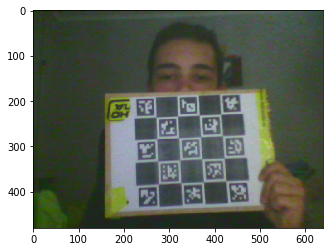

In [4]:
im = PIL.Image.open(images[0])
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(im)
#ax.axis('off')
plt.show()

Now, the camera calibration can be done using all the images of the chessboard. Two functions are necessary:

* The first will detect markers on all the images and.
* The second will proceed the detected markers to estimage the camera calibration data.

In [5]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        
        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner, 
                                 winSize = (3,3), 
                                 zeroZone = (-1,-1), 
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              
        
        decimator+=1   

    imsize = gray.shape
    return allCorners,allIds,imsize

In [6]:
allCorners,allIds,imsize=read_chessboards(images)
print(imsize)

POSE ESTIMATION STARTS:
=> Processing image ./../data/calib_tel_ludo_removed_camera/2019-05-19-003431.jpg
=> Processing image ./../data/calib_tel_ludo_removed_camera/2019-05-19-003454.jpg
=> Processing image ./../data/calib_tel_ludo_removed_camera/2019-05-19-003512.jpg
=> Processing image ./../data/calib_tel_ludo_removed_camera/2019-05-19-003517.jpg
=> Processing image ./../data/calib_tel_ludo_removed_camera/2019-05-19-003527.jpg
=> Processing image ./../data/calib_tel_ludo_removed_camera/2019-05-19-003533.jpg
=> Processing image ./../data/calib_tel_ludo_removed_camera/2019-05-19-003542.jpg
=> Processing image ./../data/calib_tel_ludo_removed_camera/2019-05-19-003550.jpg
=> Processing image ./../data/calib_tel_ludo_removed_camera/2019-05-19-003558.jpg
=> Processing image ./../data/calib_tel_ludo_removed_camera/2019-05-19-003607.jpg
=> Processing image ./../data/calib_tel_ludo_removed_camera/2019-05-19-003613.jpg
=> Processing image ./../data/calib_tel_ludo_removed_camera/2019-05-19-003

In [7]:
def calibrate_camera(allCorners,allIds,imsize):   
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")
    
    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO) 
    #flags = (cv2.CALIB_RATIONAL_MODEL) 
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [8]:
%time ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

CAMERA CALIBRATION
CPU times: user 1.24 s, sys: 0 ns, total: 1.24 s
Wall time: 1.24 s


In [9]:
ret

0.3651898004635953

In [10]:
mtx

array([[730.42192194,   0.        , 326.77045236],
       [  0.        , 730.42192194, 250.04660976],
       [  0.        ,   0.        ,   1.        ]])

In [11]:
dist

array([[ 6.32701239e+00],
       [-1.00584886e+02],
       [ 8.29213322e-03],
       [ 6.35408371e-03],
       [ 2.64780741e+02],
       [ 5.79086179e+00],
       [-9.59813367e+01],
       [ 2.54024350e+02],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

### Check calibration results

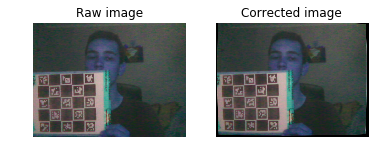

In [12]:
i=1 # select image id
plt.figure()
frame = cv2.imread(images[i])
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

### Сохраняем данные калибровки

In [18]:
import pickle

In [19]:
f = open("data_of_calibrate_camera.pckl", "wb")
pickle.dump(ret, f)
pickle.dump(mtx, f)
pickle.dump(dist, f)
pickle.dump(rvecs, f)
pickle.dump(tvecs, f)
f.close()

In [20]:
#Синтаксис чтения из файла
f = open("data_of_calibrate_camera.pckl", "rb")
ret = pickle.load(f)
mtx = pickle.load(f)
dist = pickle.load(f)
rvecs = pickle.load(f)
tvecs = pickle.load(f)